# Import Data (replies already been excluded)

In [24]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
import pandas as pd

text = pd.read_csv('Jan6(excludes replies).csv')
text2 = pd.read_csv('Frey transcripts.csv')
print('The number of tweets (excludes replies) before data pre-processing:',len(text2))

The number of tweets (excludes replies) before data pre-processing: 6501


In [25]:
text2

,Unnamed: 0,tweets,date,Company,url
0,0.0,Scene 4\n\nLars: [00:15:35] 35. [00:15:30]\n\n...,1/5/21 15:59,transcript 1,https://twitter.com/MemphisMeats/status/134648...
1,1.0,scene_2.wav\nElizabeth: [00:00:01] This is my ...,12/30/20 23:14,transcript 2,https://twitter.com/MemphisMeats/status/134442...
2,2.0,scene_3.wav\nLindsey: [00:00:03] Before I was ...,12/23/20 19:00,transcript 3,https://twitter.com/MemphisMeats/status/134182...
3,4.0,Scene 4\n\nLars: [00:15:35] 35. [00:15:30]\n\n...,12/16/20 21:26,transcript 4,https://twitter.com/MemphisMeats/status/133932...
4,5.0,Scene 5\n\nElizabeth: [00:21:32] So [00:21:30]...,12/15/20 20:16,transcript 5,https://twitter.com/MemphisMeats/status/133894...
...,...,...,...,...,...
6496,NaN,NaN,NaN,NaN,NaN
6497,NaN,NaN,NaN,NaN,NaN
6498,NaN,NaN,NaN,NaN,NaN
6499,NaN,NaN,NaN,NaN,NaN


In [4]:
from lda import guidedlda

# Data Cleaning
1. tokenization
2. remove @users, hashtag symbols, Urls, and special symbols(i.e., '&amp'), non-alphabetic characters, and words that have less than 3 characters
3. remove stopwords
4. lowercase transformation
5. stemming

In [26]:
import gensim
import gensim.corpora as corpora
import re
porter = PorterStemmer()
stop_words = stopwords.words('english')
b = []
for i,u in text2.iterrows():
    a = []
    word =''
    for words in str(u['tweets']).split(): #tokenization
        if '@' not in words: #remove @users
            words = words.replace('#','') #remove hashtag symbol
            if '#' not in words:
                if 'http' not in words: #remove URLs
                    if'&amp' not in words: #remove symbol
                        words = re.sub(r'[^a-zA-Z]', ' ', words)#remove non-alphabetic characters
                        if len(words)>2:
                            word += (words+' ')
    doc = ''
    for token in word.split():
        if len(token) >2: # remove words that have less than 3 characters
            token = token.lower()# lowercase form
            if token not in stop_words:# remove stopwords
                token = porter.stem(token) #stemming
                doc += (token+' ')
    b.append(doc)
text2['processed']=[i for i in b]

# exclude tweets that are not in English
non_english_list = ['temiz','rkiy','erik','nda','konu','dan','da','ba','al','viand','para','na','dann','uft','laboratorio','dieser','kalbimi',
                   'restoranda','evento','komo','ind','tica','futuro','sonra','yla','cre','ili','daki',
                   'zaman']
index_axis = []
for index,i in text2.iterrows():
    if len(i['processed']) == 0:
        index_axis.append(index)
    else:
        for word in i['processed'].split():
            if word in non_english_list:
                index_axis.append(index)
                break
text2.drop(text2.index[index_axis],inplace=True)
print("number of tweets after cleaning:",len(text2))

number of tweets after cleaning: 6501


In [27]:
text2.groupby('Company')['tweets'].count().sort_values(ascending=False)

Company
transcript 1     1
transcript 10    1
transcript 11    1
transcript 12    1
transcript 13    1
transcript 14    1
transcript 2     1
transcript 3     1
transcript 4     1
transcript 5     1
transcript 6     1
transcript 7     1
transcript 8     1
transcript 9     1
Name: tweets, dtype: int64

# Randomly Select 20% Dataset As Our Training Set

In [28]:
text_random_20percent = text2.sample(frac=0.2, random_state=2022)

In [29]:
text_random_20percent.groupby('Company')['tweets'].count().sort_values(ascending=False)

Company
transcript 2    1
transcript 3    1
Name: tweets, dtype: int64

# Generate Bigrams

INFO:gensim.models.phrases:collecting all words and their counts
INFO:gensim.models.phrases:PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:gensim.models.phrases:collected 829 token types (unigram + bigrams) from a corpus of 1856 words and 1300 sentences
INFO:gensim.models.phrases:merged Phrases<829 vocab, min_count=1, threshold=1, max_vocab_size=40000000>
INFO:gensim.utils:Phrases lifecycle event {'msg': 'built Phrases<829 vocab, min_count=1, threshold=1, max_vocab_size=40000000> in 0.00s', 'datetime': '2022-07-14T13:23:35.345434', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO:gensim.models.phrases:exporting phrases from Phrases<829 vocab, min_count=1, threshold=1, max_vocab_size=40000000>
INFO:gensim.utils:FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<32 phrases, min_count=1, threshold=1> from Phrases<829 vocab, min_count=1, threshold=1, m

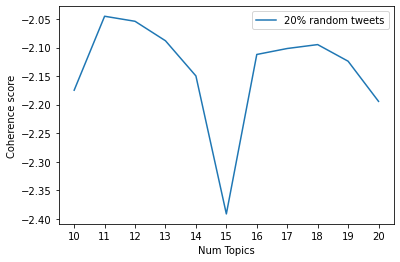

In [30]:
from gensim.models import CoherenceModel
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True)) #tokenization，return a list
data_words = list(sent_to_words(text_random_20percent['processed'])) #tokenization
bigram = gensim.models.Phrases(data_words,min_count=1,threshold=1)
'''mincount：int, the times that two unigram co-occur must be equal or higher than this number，
threshold：Phrases function will return a 'phrase score', it will decide whether two unigrams can be regarded as a bigram'''
bigram_mod = gensim.models.phrases.Phraser(bigram) # Bigram
def make_bigrams(texts): #Bigram
    return [bigram[doc] for doc in texts]
data_words_bigrams = make_bigrams(data_words)
id2word = corpora.Dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]


def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start,limit,step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,random_state=2022)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
limit=21; start=10; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
# Show graph
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values,label='20% random tweets')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')
plt.xticks(range(start,limit,step))
plt.show()

According to the Coherence score **Umass**, we set the number of topics to **12**

In [125]:
print('The number of tweets in the training set:',len(texts))

The number of tweets in the training set: 1300


# Traditional Bigram LDA
print out the top 50 bigrams in each topic

In [31]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=12,random_state=2022,alpha='auto',per_word_topics=True)

amount =0
for idx, topic in lda_model.show_topics(formatted=False,num_topics=12,num_words= 500):
    print('\n',end='')
    print('Topic:',idx)
    num = 0
    for w in topic:
        if '_' in w[0] and num < 50:
            #print(round(w[1],4),'*',w[0],', ',end='',sep='')
            print('(',w[0],') ',end='',sep='')
            num += 1 
            amount+=1

INFO:gensim.models.ldamodel:using autotuned alpha, starting with [0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336, 0.083333336]
INFO:gensim.models.ldamodel:using symmetric eta at 0.08333333333333333
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 12 topics, 1 passes over the supplied corpus of 1300 documents, updating model once every 1300 documents, evaluating perplexity every 1300 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:-10.518 per-word bound, 1466.2 perplexity estimate based on a held-out corpus of 1300 documents with 1809 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #1300/1300
INFO:gensim.models.ldamodel:optimized alpha [0.07728599, 0.07657245, 0.07650697, 0.07659276, 0.08131927, 0.07678238, 0.07665067, 0.14546846, 0.07658926, 0.0


Topic: 0
(job_line) (everi_singl) (think_track) (grown_overnight) (made_decis) (came_home) (someth_wrong) (seriou_relationship) (scare_parent) (know_like) (one_thing) (scene_wav) (elizabeth_ye) (sinc_last) (record_male) (breath_breath) (voic_take) (part_bodi) (nurs_tell) (pleas_breath) (breath_take) (huge_huge) (hold_pleas) (real_deep) (deep_breath) (breath_hold) (anoth_real) (take_anoth) 
Topic: 1
(voic_take) (record_male) (elizabeth_ye) (part_bodi) (sinc_last) (breath_breath) (nurs_tell) (take_anoth) (anoth_real) (breath_hold) (one_thing) (hold_pleas) (real_deep) (deep_breath) (breath_take) (huge_huge) (know_like) (pleas_breath) (scene_wav) (everi_singl) (someth_wrong) (came_home) (scare_parent) (job_line) (think_track) (made_decis) (grown_overnight) (seriou_relationship) 
Topic: 2
(breath_breath) (elizabeth_ye) (sinc_last) (nurs_tell) (voic_take) (part_bodi) (record_male) (breath_hold) (know_like) (huge_huge) (real_deep) (take_anoth) (breath_take) (one_thing) (anoth_real) (deep_bre

# GuidedLDA Model
latent topics are identified from the bigrams shown above.

In [40]:
bigramseed = [['god','hope','pray','believe','trust','church','conviction','optimism','religion',
               'ideaology','confidence','group','relationship','mass','synagogue','anticipate',
               'future','strong','want','lord','ready','wait','focus','positive','plan','scare',
               'support','desire','acceptance','loyal','truth','allegiance','assent','assurance',
               'certain','constant','credence','credit','credulity','depend','fealty','fidelity',
               'reliance','stock','store','sureness','surety','troth'],#0 Faith
             ['tumor','radiology','chemotherapy','benign','invasive','masectomy','surgery',
              'malignant','metastasis','melanoma','carcigen','cancerous','precancerous',
              'survivor','disease','sick','ill','spread','lump','cell','grow','neck','body',
             'organ','lungs','heal','emergency','oncologist','prescription','m.d.','test','passed',
             'prognosis','migrane','seizure','c.t.','scan','imaging','heartbeat','diagnosis','biopsy',
             'removed','corruption','carcinoma','big c'],#1 cancer
             ['earth','sun','sky','stars','trees','flowers','land','sea','ocean','lake','river','rain',
             'storm','thunder','lightening','snow','sunset','sunrise','outside','leaf','trek','wilderness',
              'animal','stream','rock','bolt','flood','weather','water','hurricane','mold','morning','night',
              'shellfish','ground','world','trash','life','track','environment','landscape','view','cosmos',
              'country','forest','generation','macrocosm','outdoor','scenery','seascape','setting','universe',
              'natural',],#2 Nature
             ['reflection','care','self care','health','caution','consideration',
              'conscientious','regard','thought','thougt','wellness','well-being','feelings','mental health','maintenance','introspection',
             'center','concentrate','breath','relax','sit','focus','ground','listen','yoga','body','hardships','redifine','strong','experience',
             'tough','sign','know','heal','sleep','nerve','positive','mind','heavy','activity','headache','deep','body','sense','tension','pause',
              'notice','heartbeat','move','forward','weight','depression','heart','check','support','self-esteem',
             'confident','alertness','carefulness','circumspection','concern','diligence','direction','discrimination','effort','enthusiasm',
             'exactness','exertion','fastidiousness','forethougt','head','heedfulness','interest','management','meticulousness','nicety','pain',
              'particularity','precaution','prudence','regard','scrupulousness','solicitude']]#3 Mindfullness

from sklearn.feature_extraction.text import CountVectorizer
from lda import guidedlda as guidedlda
import numpy as np
model = guidedlda.GuidedLDA(n_topics=4,n_iter=1000,random_state=2022,refresh=10,alpha=0.01,eta=0.01)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text2['processed'])

vocab = vectorizer.get_feature_names()
word2id = dict((v,idx) for idx,v in enumerate(vocab))
seed_topics = {}
for t_id, st in enumerate(bigramseed):
    for word in st:
        try:
            seed_topics[word2id[word]] = t_id
        except:
            print(word," skipped")

model.fit(X.toarray(),seed_topics=seed_topics,seed_confidence=0.7) #set seed confidence to 0.7
topic_word = model.topic_word_
n_top_words = 20
vocab = tuple(vocab)

for i, topic_dist in enumerate(topic_word): #Print out results
    print('\n')
    print('Topic:',i)
    words_probability = np.array(-topic_dist)
    for index in range(n_top_words):
        print(round(abs(np.sort(words_probability))[:(n_top_words)][index],4),'*',
              np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1][index],sep='',end='  ') 

INFO:lda:n_documents: 6501
INFO:lda:vocab_size: 733
INFO:lda:n_words: 8737
INFO:lda:n_topics: 4
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -34968


believe  skipped
trust  skipped
church  skipped
conviction  skipped
optimism  skipped
religion  skipped
ideaology  skipped
confidence  skipped
mass  skipped
synagogue  skipped
anticipate  skipped
future  skipped
lord  skipped
ready  skipped
focus  skipped
positive  skipped
desire  skipped
acceptance  skipped
loyal  skipped
truth  skipped
allegiance  skipped
assent  skipped
assurance  skipped
certain  skipped
constant  skipped
credence  skipped
credit  skipped
credulity  skipped
depend  skipped
fealty  skipped
fidelity  skipped
reliance  skipped
stock  skipped
store  skipped
sureness  skipped
surety  skipped
troth  skipped
radiology  skipped
chemotherapy  skipped
benign  skipped
invasive  skipped
masectomy  skipped
surgery  skipped
malignant  skipped
metastasis  skipped
melanoma  skipped
carcigen  skipped
cancerous  skipped
precancerous  skipped
survivor  skipped
disease  skipped
sick  skipped
ill  skipped
spread  skipped
lump  skipped
cell  skipped
body  skipped
organ  skipped
lungs  s

INFO:lda:<10> log likelihood: -30256
INFO:lda:<20> log likelihood: -29379
INFO:lda:<30> log likelihood: -28737
INFO:lda:<40> log likelihood: -27996
INFO:lda:<50> log likelihood: -27590
INFO:lda:<60> log likelihood: -26466
INFO:lda:<70> log likelihood: -26234
INFO:lda:<80> log likelihood: -26136
INFO:lda:<90> log likelihood: -25905
INFO:lda:<100> log likelihood: -25928
INFO:lda:<110> log likelihood: -25865
INFO:lda:<120> log likelihood: -25884
INFO:lda:<130> log likelihood: -25865
INFO:lda:<140> log likelihood: -25865
INFO:lda:<150> log likelihood: -25865
INFO:lda:<160> log likelihood: -25865
INFO:lda:<170> log likelihood: -25865
INFO:lda:<180> log likelihood: -25865
INFO:lda:<190> log likelihood: -25865
INFO:lda:<200> log likelihood: -25865
INFO:lda:<210> log likelihood: -25865
INFO:lda:<220> log likelihood: -25865
INFO:lda:<230> log likelihood: -25865
INFO:lda:<240> log likelihood: -25865
INFO:lda:<250> log likelihood: -25865
INFO:lda:<260> log likelihood: -25865
INFO:lda:<270> log li



Topic: 0
0.9966*nan  0.0*young  0.0*give  0.0*gosh  0.0*good  0.0*gonna  0.0*gone  0.0*goe  0.0*god  0.0*goat  0.0*go  0.0*given  0.0*get  0.0*freak  0.0*gener  0.0*gear  0.0*futur  0.0*fun  0.0*full  0.0*fulfil  

Topic: 1
0.9967*nan  0.0*young  0.0*give  0.0*gosh  0.0*good  0.0*gonna  0.0*gone  0.0*goe  0.0*god  0.0*goat  0.0*go  0.0*given  0.0*get  0.0*freak  0.0*gener  0.0*gear  0.0*futur  0.0*fun  0.0*full  0.0*fulfil  

Topic: 2
0.9961*nan  0.0005*tape  0.0*young  0.0*get  0.0*gonna  0.0*gone  0.0*goe  0.0*god  0.0*goat  0.0*go  0.0*given  0.0*give  0.0*gear  0.0*gener  0.0*gosh  0.0*futur  0.0*fun  0.0*full  0.0*fulfil  0.0*fuck  

Topic: 3
0.0173*right  0.0168*like  0.0124*yeah  0.0124*lindsey  0.0124*know  0.0111*one  0.0106*elizabeth  0.0106*lar  0.0098*come  0.0093*realli  0.0084*see  0.008*would  0.0071*get  0.0071*think  0.0071*year  0.0071*feel  0.0067*deni  0.0067*time  0.0067*cancer  0.0067*guid  

In [54]:
seed_topics

{244: 0,
 295: 0,
 482: 0,
 261: 0,
 513: 0,
 617: 3,
 693: 0,
 690: 0,
 469: 0,
 542: 0,
 623: 3,
 674: 1,
 262: 1,
 407: 1,
 433: 1,
 642: 1,
 540: 1,
 277: 3,
 154: 2,
 621: 2,
 328: 2,
 527: 2,
 500: 2,
 528: 2,
 214: 2,
 694: 2,
 416: 2,
 566: 2,
 260: 3,
 718: 2,
 667: 2,
 341: 2,
 665: 2,
 220: 2,
 440: 2,
 91: 3,
 273: 3,
 645: 3,
 72: 3,
 582: 3,
 574: 3,
 326: 3,
 586: 3,
 390: 3,
 133: 3,
 638: 3,
 399: 3,
 225: 3,
 700: 3,
 276: 3,
 97: 3}

In [50]:
# list(enumerate(bigramseed))

In [137]:
word2id[word]

KeyError: 'God'

In [129]:
print (list(enumerate(bigramseed)))

[(0, ['foodtech', 'cellular', 'medium', 'stem', 'dprint', 'bioprint', 'cellag']), (1, ['seafood', 'sushi', 'nigiri', 'fish', 'shrimp', 'crab', 'aquacultur', 'lobster', 'salmon']), (2, ['steak', 'poultri', 'beef', 'chicken', 'duck']), (3, ['climat', 'chang', 'carbon', 'sustain', 'sustainablefood', 'sustainablemeat', 'feed', 'serv', 'demand']), (4, ['altprotein', 'altern', 'protein', 'alt', 'plant', 'plantbas', 'vegan']), (5, ['slaughter', 'cruelti', 'harm', 'anim', 'kill', 'welfar']), (6, ['healthi', 'healthier', 'health', 'fat']), (7, ['market', 'product', 'industri', 'suppli', 'chain', 'commerci']), (8, ['invest', 'startup', 'round', 'seed', 'fund', 'backer']), (9, ['demo', 'event', 'speak', 'host', 'festiv', 'symposium', 'join', 'talk', 'goodfoodconfer', 'watch', 'live', 'podcast', 'news', 'read', 'blog', 'post', 'check', 'interview', 'articl', 'thank', 'announc', 'discuss']), (10, ['join', 'team', 'hire']), (11, ['fda', 'usda', 'approv', 'advoc'])]


# Prominent Factor
For any tweet, let *t1* be the topic with the highest probability (*p1*) and the *t2* the next ranking topic (with probability *p2*), as determined by performing Guided LDA on the entire dadaset. We call the ratio of *p1*/*p2* the 'Prominent Factor' or PF. If *t1* is much more prominent than '*t2*', PF will be high. A factor higher than 1.4 means that one topic is relatively predominant for this tweet.

*References:*

Nugroho, Robertus, et al. "Incorporating tweet relationships into topic derivation." Conference of the Pacific Association for Computational Linguistics. Springer, Singapore, 2015.


In [41]:
prominent_factor = []
doc_topic = model.transform(X)
for i in range(len(doc_topic)):
    prominent_factor.append(sorted(doc_topic[i])[-1]/sorted(doc_topic[i])[-2])
count = 0
for i in prominent_factor:
    if i >= 1.4:
        count+=1
print('Prominent factor:',round(count/len(text)*100,2),'%',sep='')

Prominent factor:0.22%


# Proportion of Each Topic

In [42]:
topic_number = []
number = []
topic_probability = []
for i in range(len(doc_topic)):
    topic_number.append(doc_topic[i].argmax())
    topic_probability.append(doc_topic[i][doc_topic[i].argmax()])
    number.append('1')
data = pd.DataFrame(data=[i for i in topic_number],columns=['topic_number'])
data['number'] = [i for i in number]
number_of_tweets = pd.DataFrame(data.groupby('topic_number')['number'].count())
number_of_tweets['proportion'] = [str(round(i/len(text)*100,2))+'%' for i in number_of_tweets['number']]
number_of_tweets['Topic'] = ['Manufacturing process','Seafood','Meat product','Sustainability',
                                 'Alternative protein','Animal welfare','Health and nutrition','Industry and market',
                                 'Fundraising','Event promotion and media release','Hiring information',
                                 'Regulation','Unseeded topic1','Unseeded topic2']
number_of_tweets

ValueError: Length of values (14) does not match length of index (2)

# Company-Topic Heatmap
Based on proportion of each topic for each company

In [45]:
doc_topic = model.transform(X)
topic_number1 = []


for i in range(len(doc_topic)):
    topic_number1.append(doc_topic[i].argmax())
text2['topic number'] = [i for i in topic_number1]
# topic_author = text2.groupby(['topic number','Company'])['tweets'].count()
# topic_author_3d = topic_author.unstack()
# topic_author_3d = topic_author_3d[['Memphis Meats','biftek.co 🔬👩‍🔬🐄🥗','Aleph Farms','SuperMeat',
#                                   'Finless Foods','shiokmeats','BlueNalu','New Age Meats','CUBIQ FOODS',
#                                   'Mosa Meat','Wildtype','Meatable','Future Fields','Vow',
#                                   'FutureMeat','Balletic Foods','LabFarmFoods','Avant Meats','Mission Barns']]
# topic = ['Manufacturing process and supplies','Seafood product','Meat product','Sustainability',
#         'Animal welfare','Alternative protein','Health and nutrition','Regulation','Industry and market','Fundraising',
#         'Hiring Information','Event promotion and media release','Unseeded topic 1','Unseeded topic 2']

# company = ['UPSIDE Foods','Biftek.co','Aleph Farms','SuperMeat','Fineless Foods','Shiok Meats','BlueNalu',
#           'New Age Meats','Cubiq Foods','Mosa Meat','Wild Type','Meatable','Future Fields','Vow','Future Meat',
#            'Balletic Foods','Lab Farm Foods','Avant Meats','Mission Barns']
# topic_author_3d = topic_author_3d.fillna(0)#replace NaN by 0
# topic_author_3d = topic_author_3d.reindex([0,1,2,3,5,4,6,11,7,8,10,9,12,13])# reindex
# import matplotlib.pyplot as plt
# plt.figure(figsize=(11,8))
# plt.imshow(topic_author_3d.div(topic_author_3d.sum(axis=0),axis=1),cmap="Blues")
# plt.colorbar().ax.set_ylabel('Proportion of each topic for each company')
# plt.xticks(range(len(company)), company,rotation=90)
# plt.yticks(range(len(topic)), topic)
# plt.xlabel('Company')
# plt.ylabel('Topic')
# plt.show()

In [48]:
topic_number1

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [46]:
text2

,Unnamed: 0,tweets,date,Company,url,processed,topic number
0,0.0,Scene 4\n\nLars: [00:15:35] 35. [00:15:30]\n\n...,1/5/21 15:59,transcript 1,https://twitter.com/MemphisMeats/status/134648...,scene lar lar know bag everyth yeah yeah one t...,3
1,1.0,scene_2.wav\nElizabeth: [00:00:01] This is my ...,12/30/20 23:14,transcript 2,https://twitter.com/MemphisMeats/status/134442...,scene wav elizabeth case run realli fast away ...,3
2,2.0,scene_3.wav\nLindsey: [00:00:03] Before I was ...,12/23/20 19:00,transcript 3,https://twitter.com/MemphisMeats/status/134182...,scene wav lindsey diagnos still colleg found t...,3
3,4.0,Scene 4\n\nLars: [00:15:35] 35. [00:15:30]\n\n...,12/16/20 21:26,transcript 4,https://twitter.com/MemphisMeats/status/133932...,scene lar lar know bag everyth yeah yeah one t...,3
4,5.0,Scene 5\n\nElizabeth: [00:21:32] So [00:21:30]...,12/15/20 20:16,transcript 5,https://twitter.com/MemphisMeats/status/133894...,scene elizabeth saw hematologist oncologist fi...,3
...,...,...,...,...,...,...,...
6496,NaN,NaN,NaN,NaN,NaN,nan,1
6497,NaN,NaN,NaN,NaN,NaN,nan,1
6498,NaN,NaN,NaN,NaN,NaN,nan,1
6499,NaN,NaN,NaN,NaN,NaN,nan,1


In [44]:
text2

,Unnamed: 0,tweets,date,Company,url,processed,topic number
0,0.0,Scene 4\n\nLars: [00:15:35] 35. [00:15:30]\n\n...,1/5/21 15:59,transcript 1,https://twitter.com/MemphisMeats/status/134648...,scene lar lar know bag everyth yeah yeah one t...,3
1,1.0,scene_2.wav\nElizabeth: [00:00:01] This is my ...,12/30/20 23:14,transcript 2,https://twitter.com/MemphisMeats/status/134442...,scene wav elizabeth case run realli fast away ...,3
2,2.0,scene_3.wav\nLindsey: [00:00:03] Before I was ...,12/23/20 19:00,transcript 3,https://twitter.com/MemphisMeats/status/134182...,scene wav lindsey diagnos still colleg found t...,3
3,4.0,Scene 4\n\nLars: [00:15:35] 35. [00:15:30]\n\n...,12/16/20 21:26,transcript 4,https://twitter.com/MemphisMeats/status/133932...,scene lar lar know bag everyth yeah yeah one t...,3
4,5.0,Scene 5\n\nElizabeth: [00:21:32] So [00:21:30]...,12/15/20 20:16,transcript 5,https://twitter.com/MemphisMeats/status/133894...,scene elizabeth saw hematologist oncologist fi...,3
...,...,...,...,...,...,...,...
6496,NaN,NaN,NaN,NaN,NaN,nan,1
6497,NaN,NaN,NaN,NaN,NaN,nan,1
6498,NaN,NaN,NaN,NaN,NaN,nan,1
6499,NaN,NaN,NaN,NaN,NaN,nan,1


# Traditional Unigram LDA

In [14]:
unigram = []
all_tweets = []
for i,tweet in text.iterrows():
    if len(unigram) != 0:
        all_tweets.append(unigram)
    unigram= []
    for word in tweet['processed'].split():
        unigram.append(str(word))
all_tweets.append(unigram)

In [15]:
unigram = []
unigram_list = []
for index, i in text.iterrows():
    unigram=[]
    for word in i['processed'].split():
        unigram.append(word)
    unigram_list.append(unigram)
data_words = [i for i in unigram_list]
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=14,random_state=2022,alpha=0.01,eta=0.01,per_word_topics=True)
lda_model.print_topics(num_words=20)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(7520 unique tokens: ['base', 'becam', 'cell', 'cellag', 'cellbasedmeat']...) from 6248 documents (total 74569 corpus positions)
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 14 topics, 1 passes over the supplied corpus of 6248 documents, updating model once every 2000 documents, evaluating perplexity every 6248 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/6248
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 6248 documents
INFO:gensim.models.ldamodel:topic #3 (0.010): 0.069*"meat" + 0.019*"food" + 0.014*"futur" + 0.013*"make" + 0.013*"via" + 0.013*"product" + 0.011*"sustain" + 0.011*"cultur" + 0.010*"anim" + 0.010*"compani"
INFO:gensim.models.ldamodel:

[(0,
  '0.043*"cleanmeat" + 0.040*"steak" + 0.021*"foodtech" + 0.018*"cellag" + 0.017*"futureoffood" + 0.017*"cultivatedmeat" + 0.017*"world" + 0.016*"culturedmeat" + 0.016*"first" + 0.015*"farm" + 0.014*"cellbasedmeat" + 0.013*"cm" + 0.013*"biotech" + 0.012*"food" + 0.012*"via" + 0.012*"meat" + 0.011*"cellularagricultur" + 0.011*"make" + 0.011*"cell" + 0.011*"grown"'),
 (1,
  '0.052*"goodfoodconfer" + 0.033*"meat" + 0.025*"food" + 0.023*"plantbas" + 0.021*"billion" + 0.014*"get" + 0.012*"burger" + 0.011*"new" + 0.011*"sustain" + 0.010*"protein" + 0.010*"industri" + 0.010*"sept" + 0.010*"talk" + 0.009*"great" + 0.009*"impact" + 0.008*"anim" + 0.008*"see" + 0.008*"acceler" + 0.008*"futur" + 0.008*"action"'),
 (2,
  '0.037*"meat" + 0.024*"product" + 0.020*"sale" + 0.018*"lab" + 0.015*"grown" + 0.013*"like" + 0.013*"launch" + 0.012*"interview" + 0.012*"wrap" + 0.012*"cell" + 0.011*"space" + 0.011*"plant" + 0.010*"replac" + 0.010*"star" + 0.010*"cleanmeat" + 0.009*"cultiv" + 0.009*"protein

In [16]:
coherencemodel = CoherenceModel(model=lda_model, texts=unigram_list, dictionary=id2word, coherence='u_mass')
coherencemodel.get_coherence()

INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 1000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 2000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 3000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 4000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 5000 documents
INFO:gensim.topic_coherence.text_analysis:CorpusAccumulator accumulated stats from 6000 documents


-6.73612562449334

# Hellinger Distance:
![HD.png](HD.png)
# Entropy:
![Entropy.png](Entropy.png)

In [17]:
import math
def calculate_entropy(topic_word_distribution,num_of_topics):
    entropy = 0
    for topic in topic_word_distribution:
        for probability in topic:
            entropy -= probability*math.log(probability)
    return entropy/num_of_topics  
from gensim.matutils import hellinger
def calculate_hellinger_distance(topic_word,number_of_topics):
    distance = 0
    for i in range(0,number_of_topics-1):
        for j in range(i+1,number_of_topics):
            distance += hellinger(topic_word[i],topic_word[j])
    return distance*2/(number_of_topics*(number_of_topics-1))
def Evaluate(seedtopic,number_of_unseededtopic):
    number_of_topic = len(seedtopic)+number_of_unseededtopic #seeded topics + 2 unseeded topics
    model = guidedlda.GuidedLDA(n_topics=number_of_topic,n_iter=1000,random_state=2022,refresh=10,alpha=0.01,eta=0.01)#9 ok
    seed_topics = {}
    for t_id, st in enumerate(seedtopic):
        for word in st:
            seed_topics[word2id[word]] = t_id

    data_words = [i for i in all_tweets]
    id2word = corpora.Dictionary(data_words)
    from gensim.models import CoherenceModel
    model = model.fit(X.toarray(),seed_topics=seed_topics,seed_confidence=0.7)
    topic_word = model.topic_word_
    coherencemodel_guided_cv_seed4 = CoherenceModel(model=model, texts=all_tweets, dictionary=id2word, coherence='c_v')
    entropy_score = calculate_entropy(topic_word,number_of_topic)
    hellinger_distance = calculate_hellinger_distance(topic_word,number_of_topic)
    return coherencemodel_guided_cv_seed4.get_coherence() , entropy_score, hellinger_distance

In [18]:
Evaluate(bigramseed,2)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(7520 unique tokens: ['base', 'becam', 'cell', 'cellag', 'cellbasedmeat']...) from 6248 documents (total 74569 corpus positions)
INFO:guidedlda:n_documents: 6248
INFO:guidedlda:vocab_size: 7520
INFO:guidedlda:n_words: 74569
INFO:guidedlda:n_topics: 14
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -978900
INFO:guidedlda:<10> log likelihood: -624493
INFO:guidedlda:<20> log likelihood: -610005
INFO:guidedlda:<30> log likelihood: -602178
INFO:guidedlda:<40> log likelihood: -598280
INFO:guidedlda:<50> log likelihood: -594905
INFO:guidedlda:<60> log likelihood: -592685
INFO:guidedlda:<70> log likelihood: -591103
INFO:guidedlda:<80> log likelihood: -589407
INFO:guidedlda:<90> log likelihood: -588374
INFO:guidedlda:<100> log likelihood: -587394
INFO:guidedlda:<110> log likelihood: -586658
INFO:guidedlda:<120> log likelihood: -586134
INFO:guidedlda

(0.7881332790526823, 6.012459103383283, 0.8141072818656245)

In [19]:
lda_topics = lda_model.get_topics() #The topic-word distribution return by traditional LDA

In [20]:
calculate_entropy(lda_topics,14) #Calculate the entropy of the results of traditional LDA model

5.569550429546264

In [21]:
calculate_hellinger_distance(lda_topics,14) #Calculate the hellinger distance of the results of traditional LDA model

0.7084897920519022

In [22]:
#unigram
from gensim.models import CoherenceModel
unigram = []
unigram_list = []
for index, i in text.iterrows():
    unigram=[]
    for word in i['processed'].split():
        unigram.append(word)
    unigram_list.append(unigram)
data_words = [i for i in unigram_list]
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
'''def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start,limit,step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,random_state=2022)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
#coherence score
limit=21; start=10; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
# Show graph
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values,label='All tweets')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')
plt.show()'''

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(7520 unique tokens: ['base', 'becam', 'cell', 'cellag', 'cellbasedmeat']...) from 6248 documents (total 74569 corpus positions)


'def compute_coherence_values(dictionary, corpus, texts, limit, start, step):\n    coherence_values = []\n    model_list = []\n    for num_topics in range(start,limit,step):\n        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,random_state=2022)\n        model_list.append(model)\n        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=\'c_v\')\n        coherence_values.append(coherencemodel.get_coherence())\n    return model_list, coherence_values\n#coherence score\nlimit=21; start=10; step=1\nmodel_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)\n# Show graph\nimport matplotlib.pyplot as plt\nx = range(start, limit, step)\nplt.plot(x, coherence_values,label=\'All tweets\')\nplt.xlabel("Num Topics")\nplt.ylabel("Coherence score")\nplt.legend(loc=\'best\')\nplt.show()'

In [23]:
CoherenceModel(model=lda_model, texts=all_tweets, dictionary=id2word, coherence='c_v').get_coherence()

INFO:gensim.topic_coherence.probability_estimation:using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topic_coherence.text_analysis:serializing accumulator to return to master...
INFO:gensim.topic_coherence.text_analysis:accumulator serialized
INFO:gensim.topi

0.3497456953504089

## To export tweets within each topic:

text_topic0 = text2.loc[text2['most_salient_topic']== 0].sort_values('probability',ascending=False)
text_topic1 = text2.loc[text2['most_salient_topic']== 1].sort_values('probability',ascending=False)
text_topic2 = text2.loc[text2['most_salient_topic']== 2].sort_values('probability',ascending=False)
text_topic3 = text2.loc[text2['most_salient_topic']== 3].sort_values('probability',ascending=False)
text_topic4 = text2.loc[text2['most_salient_topic']== 4].sort_values('probability',ascending=False)
text_topic5 = text2.loc[text2['most_salient_topic']== 5].sort_values('probability',ascending=False)
text_topic6 = text2.loc[text2['most_salient_topic']== 6].sort_values('probability',ascending=False)
text_topic7 = text2.loc[text2['most_salient_topic']== 7].sort_values('probability',ascending=False)
text_topic8 = text2.loc[text2['most_salient_topic']== 8].sort_values('probability',ascending=False)
text_topic9 = text2.loc[text2['most_salient_topic']== 9].sort_values('probability',ascending=False)
text_topic10 = text2.loc[text2['most_salient_topic']== 10].sort_values('probability',ascending=False)
text_topic11 = text2.loc[text2['most_salient_topic']== 11].sort_values('probability',ascending=False)
text_topic12 = text2.loc[text2['most_salient_topic']== 12].sort_values('probability',ascending=False)
text_topic13 = text2.loc[text2['most_salient_topic']== 13].sort_values('probability',ascending=False)